In [1]:
import pandas as pd
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import cross_validate,GridSearchCV,KFold
from sklearn.linear_model import LogisticRegression

In [2]:
from google.colab import files
uploaded = files.upload()

Saving clean_kaggle_data_2020.csv to clean_kaggle_data_2020.csv


In [3]:
df=pd.read_csv("clean_kaggle_data_2020.csv")
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,206) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,Q7_Part_5,Q7_Part_6,Q7_Part_7,Q7_Part_8,Q7_Part_9,Q7_Part_10,Q7_Part_11,Q7_Part_12,Q7_OTHER,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_Part_9,Q9_Part_10,Q9_Part_11,Q9_OTHER,Q10_Part_1,Q10_Part_2,Q10_Part_3,Q10_Part_4,Q10_Part_5,Q10_Part_6,Q10_Part_7,...,Q31_B_Part_9,Q31_B_Part_10,Q31_B_Part_11,Q31_B_Part_12,Q31_B_Part_13,Q31_B_Part_14,Q31_B_OTHER,Q33_B_Part_1,Q33_B_Part_2,Q33_B_Part_3,Q33_B_Part_4,Q33_B_Part_5,Q33_B_Part_6,Q33_B_Part_7,Q33_B_OTHER,Q34_B_Part_1,Q34_B_Part_2,Q34_B_Part_3,Q34_B_Part_4,Q34_B_Part_5,Q34_B_Part_6,Q34_B_Part_7,Q34_B_Part_8,Q34_B_Part_9,Q34_B_Part_10,Q34_B_Part_11,Q34_B_OTHER,Q35_B_Part_1,Q35_B_Part_2,Q35_B_Part_3,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_Part_10,Q35_B_OTHER,Q24_Encoded,Q24_buckets
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,What is the highest level of formal education ...,Select the title most similar to your current ...,For how many years have you been writing code ...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming language would you recommend ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which specific automated machine learning tool...,Which specific automated machine learning tool...,Which specific automated machine learning tool...,Which specific automated machine learning tool...,Which specific automated machine learning tool...,Which specific automated machine learning tool...,Which specific automated machine learning tool...,Which specific automated machine learning tool...

#Data Cleaning

In [4]:
#convert single choice categorical variavles to dummy variables
salary=df.drop(index=0)
salary=salary.drop(columns=['Q24'])
display(salary[salary.columns[1:7]].isnull().sum(axis=0))# There's no missing value in Q1-Q6

Q1    0
Q2    0
Q3    0
Q4    0
Q5    0
Q6    0
dtype: int64

In [5]:
display(salary['Q2'].value_counts())
#type 'Prefer to self-describe' and 'Nonbinary' have too few samples and may have high contingency so we drop rows with those gender data
salary=salary.drop(salary[(salary['Q2']=='Prefer to self-describe')|(salary['Q2']=='Nonbinary')].index)
salary=pd.get_dummies(data=salary,columns=['Q1','Q2','Q3','Q4','Q5','Q6'])

Man                        8872
Woman                      1683
Prefer not to say           131
Prefer to self-describe      23
Nonbinary                    20
Name: Q2, dtype: int64

In [6]:
#other single choice columns
display(salary[['Q8','Q11','Q13','Q15','Q20','Q22','Q25','Q30','Q32','Q38']].isnull().sum(axis=0))

Q8      558
Q11     558
Q13     558
Q15     558
Q20       0
Q22       0
Q25     159
Q30    7186
Q32    9192
Q38    1250
dtype: int64

In [7]:
#we can see Q8-Q15 lost values at the same rows,so we can remove them together
salary=salary.drop(salary[salary['Q8'].isnull()].index)
#There are not many missing values in Q25 so we just drop the rows with missing Q25
salary=salary.drop(salary[salary['Q25'].isnull()].index)
display(salary[['Q8','Q11','Q13','Q15','Q20','Q22','Q25','Q30','Q32','Q38']].isnull().sum(axis=0))

Q8        0
Q11       0
Q13       0
Q15       0
Q20       0
Q22       0
Q25       0
Q30    6494
Q32    8500
Q38     891
dtype: int64

In [8]:
#for Q30 and Q32, too many values missing and we have to drop the two columns
salary=salary.drop(columns=['Q30','Q32'])
display(salary[['Q8','Q11','Q13','Q15','Q20','Q22','Q25','Q38']].isnull().sum(axis=0))

Q8       0
Q11      0
Q13      0
Q15      0
Q20      0
Q22      0
Q25      0
Q38    891
dtype: int64

In [9]:
#for Q38, we need explore the answer components
display(Counter(salary['Q38']))
#'Local development environments (RStudio, JupyterLab, etc.)' has dominant number so we replace the nan with mode
salary['Q38'].fillna('Local development environments (RStudio, JupyterLab, etc.)',inplace=True)
display(salary[['Q8','Q11','Q13','Q15','Q20','Q22','Q25','Q38']].isnull().sum(axis=0))

Counter({'Advanced statistical software (SPSS, SAS, etc.)': 580,
         'Basic statistical software (Microsoft Excel, Google Sheets, etc.)': 2614,
         'Business intelligence software (Salesforce, Tableau, Spotfire, etc.)': 637,
         'Cloud-based data software & APIs (AWS, GCP, Azure, etc.)': 571,
         'Local development environments (RStudio, JupyterLab, etc.)': 4235,
         'Other': 466,
         nan: 891})

Q8     0
Q11    0
Q13    0
Q15    0
Q20    0
Q22    0
Q25    0
Q38    0
dtype: int64

In [10]:
#for single choice Q21,there is'0' but no nan answer,we donot need to drop '0' beacause it means no one work for data science
print(salary['Q21'].isnull().sum())
Counter(salary['Q21'])

0


Counter({'0': 1884,
         '1-2': 2374,
         '10-14': 622,
         '15-19': 278,
         '20+': 2035,
         '3-4': 1613,
         '5-9': 1188})

In [11]:
#so we can convert the cleaned single choice columns to dummy variables
salary=pd.get_dummies(data=salary,columns=['Q8','Q11','Q13','Q15','Q20','Q21','Q22','Q25','Q38'])

In [12]:
#convert  values in multiple choice to (0,1) pattern
for i in range(1,337):
    salary[salary.columns[i]].fillna(0,inplace=True)
    salary[salary.columns[i]]=salary[salary.columns[i]].map(lambda x:1 if x!=0 else 0)

In [13]:
#figure out how many answers are nan in multiple choices
display('Q7',salary.query("Q7_Part_1==0 and Q7_Part_2==0 and Q7_Part_3==0 and Q7_Part_4==0 and Q7_Part_5==0 and Q7_Part_6==0 and Q7_Part_7==0 and Q7_Part_8==0 and Q7_Part_9==0 and Q7_Part_10==0 and Q7_Part_11==0 and Q7_Part_12==0 and Q7_OTHER==0").index)
display('Q9',salary.query("Q9_Part_1==0 and Q9_Part_2==0 and Q9_Part_3==0 and Q9_Part_4==0 and Q9_Part_5==0 and Q9_Part_6==0 and Q9_Part_7==0 and Q9_Part_8==0 and Q9_Part_9==0 and Q9_Part_10==0 and Q9_Part_11==0 and Q9_OTHER==0").index)
display('Q10',salary.query("Q10_Part_1==0 and Q10_Part_2==0 and Q10_Part_3==0 and Q10_Part_4==0 and Q10_Part_5==0 and Q10_Part_6==0 and Q10_Part_7==0 and Q10_Part_8==0 and Q10_Part_9==0 and Q10_Part_10==0 and Q10_Part_11==0 and Q10_Part_12==0 and Q10_Part_13==0 and Q10_OTHER==0").index)
display('Q12',salary.query("Q12_Part_1==0 and Q12_Part_2==0 and Q12_Part_3==0 and Q12_OTHER==0").index)
display('Q14',salary.query("Q14_Part_1==0 and Q14_Part_2==0 and Q14_Part_3==0 and Q14_Part_4==0 and Q14_Part_5==0 and Q14_Part_6==0 and Q14_Part_7==0 and Q14_Part_8==0 and Q14_Part_9==0 and Q14_Part_10==0 and Q14_Part_11==0 and Q14_OTHER==0").index)
display('Q16',salary.query("Q16_Part_1==0 and Q16_Part_2==0 and Q16_Part_3==0 and Q16_Part_4==0 and Q16_Part_5==0 and Q16_Part_6==0 and Q16_Part_7==0 and Q16_Part_8==0 and Q16_Part_9==0 and Q16_Part_10==0 and Q16_Part_11==0 and Q16_Part_12==0 and Q16_Part_13==0 and Q16_Part_14==0 and Q16_Part_15==0 and Q16_OTHER==0").index)
display('Q17',salary.query("Q17_Part_1==0 and Q17_Part_2==0 and Q17_Part_3==0 and Q17_Part_4==0 and Q17_Part_5==0 and Q17_Part_6==0 and Q17_Part_7==0 and Q17_Part_8==0 and Q17_Part_9==0 and Q17_Part_10==0 and Q17_Part_11==0 and Q17_OTHER==0").index)
display('Q18',salary.query("Q18_Part_1==0 and Q18_Part_2==0 and Q18_Part_3==0 and Q18_Part_4==0 and Q18_Part_5==0 and Q18_Part_6==0 and Q18_OTHER==0").index)
display('Q19',salary.query("Q19_Part_1==0 and Q19_Part_2==0 and Q19_Part_3==0 and Q19_Part_4==0 and Q19_Part_5==0 and Q19_OTHER==0").index)
display('Q23',salary.query("Q23_Part_1==0 and Q23_Part_2==0 and Q23_Part_3==0 and Q23_Part_4==0 and Q23_Part_5==0 and Q23_Part_6==0 and Q23_Part_7==0 and Q23_OTHER==0").index)
display('Q26A',salary.query("Q26_A_Part_1==0 and Q26_A_Part_2==0 and Q26_A_Part_3==0 and Q26_A_Part_4==0 and Q26_A_Part_5==0 and Q26_A_Part_6==0 and Q26_A_Part_7==0 and Q26_A_Part_8==0 and Q26_A_Part_9==0 and Q26_A_Part_10==0 and Q26_A_Part_11==0 and Q26_A_OTHER==0").index)
display('Q27A',salary.query("Q27_A_Part_1==0 and Q27_A_Part_2==0 and Q27_A_Part_3==0 and Q27_A_Part_4==0 and Q27_A_Part_5==0 and Q27_A_Part_6==0 and Q27_A_Part_7==0 and Q27_A_Part_8==0 and Q27_A_Part_9==0 and Q27_A_Part_10==0 and Q27_A_Part_11==0 and Q27_A_OTHER==0").index)
display('Q28A',salary.query("Q28_A_Part_1==0 and Q28_A_Part_2==0 and Q28_A_Part_3==0 and Q28_A_Part_4==0 and Q28_A_Part_5==0 and Q28_A_Part_6==0 and Q28_A_Part_7==0 and Q28_A_Part_8==0 and Q28_A_Part_9==0 and Q28_A_Part_10==0 and Q28_A_OTHER==0").index)
display('Q29A',salary.query("Q29_A_Part_1==0 and Q29_A_Part_2==0 and Q29_A_Part_3==0 and Q29_A_Part_4==0 and Q29_A_Part_5==0 and Q29_A_Part_6==0 and Q29_A_Part_7==0 and Q29_A_Part_8==0 and Q29_A_Part_9==0 and Q29_A_Part_10==0 and Q29_A_Part_11==0 and Q29_A_Part_12==0 and Q29_A_Part_13==0 and Q29_A_Part_14==0 and Q29_A_Part_15==0 and Q29_A_Part_16==0 and Q29_A_Part_17==0 and Q29_A_OTHER==0").index)
display('Q31A',salary.query("Q31_A_Part_1==0 and Q31_A_Part_2==0 and Q31_A_Part_3==0 and Q31_A_Part_4==0 and Q31_A_Part_5==0 and Q31_A_Part_6==0 and Q31_A_Part_7==0 and Q31_A_Part_8==0 and Q31_A_Part_9==0 and Q31_A_Part_10==0 and Q31_A_Part_11==0 and Q31_A_Part_12==0 and Q31_A_Part_13==0 and Q31_A_Part_14==0 and Q31_A_OTHER==0").index)
display('Q33A',salary.query("Q33_A_Part_1==0 and Q33_A_Part_2==0 and Q33_A_Part_3==0 and Q33_A_Part_4==0 and Q33_A_Part_5==0 and Q33_A_Part_6==0 and Q33_A_Part_7==0 and Q33_A_OTHER==0").index)
display('Q34A',salary.query("Q34_A_Part_1==0 and Q34_A_Part_2==0 and Q34_A_Part_3==0 and Q34_A_Part_4==0 and Q34_A_Part_5==0 and Q34_A_Part_6==0 and Q34_A_Part_7==0 and Q34_A_Part_8==0 and Q34_A_Part_9==0 and Q34_A_Part_10==0 and Q34_A_Part_11==0 and Q34_A_OTHER==0").index)
display('Q35A',salary.query("Q35_A_Part_1==0 and Q35_A_Part_2==0 and Q35_A_Part_3==0 and Q35_A_Part_4==0 and Q35_A_Part_5==0 and Q35_A_Part_6==0 and Q35_A_Part_7==0 and Q35_A_Part_8==0 and Q35_A_Part_9==0 and Q35_A_Part_10==0 and Q35_A_OTHER==0").index)
display('Q36',salary.query("Q36_Part_1==0 and Q36_Part_2==0 and Q36_Part_3==0 and Q36_Part_4==0 and Q36_Part_5==0 and Q36_Part_6==0 and Q36_Part_7==0 and Q36_Part_8==0 and Q36_Part_9==0 and Q36_OTHER==0").index)
display('Q37',salary.query("Q37_Part_1==0 and Q37_Part_2==0 and Q37_Part_3==0 and Q37_Part_4==0 and Q37_Part_5==0 and Q37_Part_6==0 and Q37_Part_7==0 and Q37_Part_8==0 and Q37_Part_9==0 and Q37_Part_10==0 and Q37_Part_11==0 and Q37_OTHER==0").index)
display('Q39',salary.query("Q39_Part_1==0 and Q39_Part_2==0 and Q39_Part_3==0 and Q39_Part_4==0 and Q39_Part_5==0 and Q39_Part_6==0 and Q39_Part_7==0 and Q39_Part_8==0 and Q39_Part_9==0 and Q39_Part_10==0 and Q39_Part_11==0 and Q39_OTHER==0").index)
display('Q26B',salary.query("Q26_B_Part_1==0 and Q26_B_Part_2==0 and Q26_B_Part_3==0 and Q26_B_Part_4==0 and Q26_B_Part_5==0 and Q26_B_Part_6==0 and Q26_B_Part_7==0 and Q26_B_Part_8==0 and Q26_B_Part_9==0 and Q26_B_Part_10==0 and Q26_B_Part_11==0 and Q26_B_OTHER==0").index)
display('Q27B',salary.query("Q27_B_Part_1==0 and Q27_B_Part_2==0 and Q27_B_Part_3==0 and Q27_B_Part_4==0 and Q27_B_Part_5==0 and Q27_B_Part_6==0 and Q27_B_Part_7==0 and Q27_B_Part_8==0 and Q27_B_Part_9==0 and Q27_B_Part_10==0 and Q27_B_Part_11==0 and Q27_B_OTHER==0").index)
display('Q28B',salary.query("Q28_B_Part_1==0 and Q28_B_Part_2==0 and Q28_B_Part_3==0 and Q28_B_Part_4==0 and Q28_B_Part_5==0 and Q28_B_Part_6==0 and Q28_B_Part_7==0 and Q28_B_Part_8==0 and Q28_B_Part_9==0 and Q28_B_Part_10==0 and Q28_B_OTHER==0").index)
display('Q29B',salary.query("Q29_B_Part_1==0 and Q29_B_Part_2==0 and Q29_B_Part_3==0 and Q29_B_Part_4==0 and Q29_B_Part_5==0 and Q29_B_Part_6==0 and Q29_B_Part_7==0 and Q29_B_Part_8==0 and Q29_B_Part_9==0 and Q29_B_Part_10==0 and Q29_B_Part_11==0 and Q29_B_Part_12==0 and Q29_B_Part_13==0 and Q29_B_Part_14==0 and Q29_B_Part_15==0 and Q29_B_Part_16==0 and Q29_B_Part_17==0 and Q29_B_OTHER==0").index)
display('Q31B',salary.query("Q31_B_Part_1==0 and Q31_B_Part_2==0 and Q31_B_Part_3==0 and Q31_B_Part_4==0 and Q31_B_Part_5==0 and Q31_B_Part_6==0 and Q31_B_Part_7==0 and Q31_B_Part_8==0 and Q31_B_Part_9==0 and Q31_B_Part_10==0 and Q31_B_Part_11==0 and Q31_B_Part_12==0 and Q31_B_Part_13==0 and Q31_B_Part_14==0 and Q31_B_OTHER==0").index)
display('Q33B',salary.query("Q33_B_Part_1==0 and Q33_B_Part_2==0 and Q33_B_Part_3==0 and Q33_B_Part_4==0 and Q33_B_Part_5==0 and Q33_B_Part_6==0 and Q33_B_Part_7==0 and Q33_B_OTHER==0").index)
display('Q34B',salary.query("Q34_B_Part_1==0 and Q34_B_Part_2==0 and Q34_B_Part_3==0 and Q34_B_Part_4==0 and Q34_B_Part_5==0 and Q34_B_Part_6==0 and Q34_B_Part_7==0 and Q34_B_Part_8==0 and Q34_B_Part_9==0 and Q34_B_Part_10==0 and Q34_B_Part_11==0 and Q34_B_OTHER==0").index)
display('Q35B',salary.query("Q35_B_Part_1==0 and Q35_B_Part_2==0 and Q35_B_Part_3==0 and Q35_B_Part_4==0 and Q35_B_Part_5==0 and Q35_B_Part_6==0 and Q35_B_Part_7==0 and Q35_B_Part_8==0 and Q35_B_Part_9==0 and Q35_B_Part_10==0 and Q35_B_OTHER==0").index)

'Q7'

Int64Index([], dtype='int64')

'Q9'

Int64Index([], dtype='int64')

'Q10'

Int64Index([], dtype='int64')

'Q12'

Int64Index([], dtype='int64')

'Q14'

Int64Index([], dtype='int64')

'Q16'

Int64Index([    2,    11,    27,    28,    41,    51,    70,   113,   116,
              134,
            ...
            10652, 10654, 10661, 10668, 10686, 10690, 10691, 10702, 10726,
            10727],
           dtype='int64', length=1025)

'Q17'

Int64Index([    2,    11,    27,    28,    41,    51,    70,   113,   116,
              134,
            ...
            10652, 10654, 10661, 10668, 10686, 10690, 10691, 10702, 10726,
            10727],
           dtype='int64', length=1025)

'Q18'

Int64Index([    2,     3,     5,     7,     8,     9,    10,    11,    14,
               19,
            ...
            10711, 10712, 10715, 10716, 10718, 10719, 10723, 10724, 10726,
            10727],
           dtype='int64', length=6148)

'Q19'

Int64Index([    2,     3,     4,     5,     7,     8,     9,    10,    11,
               12,
            ...
            10715, 10716, 10718, 10719, 10721, 10722, 10723, 10726, 10727,
            10729],
           dtype='int64', length=7311)

'Q23'

Int64Index([], dtype='int64')

'Q26A'

Int64Index([    7,     8,    12,    14,    22,    23,    25,    33,    34,
               38,
            ...
            10708, 10709, 10710, 10711, 10715, 10724, 10725, 10727, 10728,
            10729],
           dtype='int64', length=3123)

'Q27A'

Int64Index([    2,     5,     7,     8,     9,    12,    13,    14,    15,
               22,
            ...
            10712, 10713, 10715, 10719, 10723, 10724, 10725, 10727, 10728,
            10729],
           dtype='int64', length=5464)

'Q28A'

Int64Index([    2,     5,     7,     8,     9,    12,    13,    14,    15,
               22,
            ...
            10712, 10713, 10715, 10719, 10723, 10724, 10725, 10727, 10728,
            10729],
           dtype='int64', length=5489)

'Q29A'

Int64Index([    7,     8,    12,    14,    22,    23,    25,    33,    34,
               38,
            ...
            10708, 10709, 10710, 10711, 10715, 10724, 10725, 10727, 10728,
            10729],
           dtype='int64', length=3240)

'Q31A'

Int64Index([    7,     8,    12,    14,    22,    23,    25,    33,    34,
               38,
            ...
            10708, 10709, 10710, 10711, 10715, 10724, 10725, 10727, 10728,
            10729],
           dtype='int64', length=3289)

'Q33A'

Int64Index([    7,     8,    12,    14,    22,    23,    25,    33,    34,
               38,
            ...
            10708, 10709, 10710, 10711, 10715, 10724, 10725, 10727, 10728,
            10729],
           dtype='int64', length=3323)

'Q34A'

Int64Index([    1,     2,     3,     4,     5,     7,     8,     9,    10,
               11,
            ...
            10719, 10720, 10721, 10723, 10724, 10725, 10726, 10727, 10728,
            10729],
           dtype='int64', length=8003)

'Q35A'

Int64Index([    7,     8,    12,    14,    22,    23,    25,    33,    34,
               38,
            ...
            10708, 10709, 10710, 10711, 10715, 10724, 10725, 10727, 10728,
            10729],
           dtype='int64', length=3372)

'Q36'

Int64Index([    2,     7,     8,    12,    14,    22,    23,    25,    33,
               34,
            ...
            10708, 10709, 10710, 10711, 10715, 10724, 10725, 10727, 10728,
            10729],
           dtype='int64', length=3393)

'Q37'

Int64Index([   22,    23,    62,   103,   118,   135,   154,   166,   172,
              190,
            ...
            10627, 10638, 10654, 10665, 10669, 10682, 10684, 10701, 10702,
            10727],
           dtype='int64', length=667)

'Q39'

Int64Index([   22,    23,    37,    50,    62,    75,    81,   103,   118,
              135,
            ...
            10654, 10665, 10669, 10682, 10683, 10684, 10701, 10702, 10712,
            10727],
           dtype='int64', length=935)

'Q26B'

Int64Index([    1,     3,     4,     5,     6,     9,    10,    13,    15,
               16,
            ...
            10713, 10714, 10716, 10717, 10718, 10719, 10720, 10721, 10722,
            10723],
           dtype='int64', length=6478)

'Q27B'

Int64Index([    1,     2,     3,     4,     5,     6,     9,    10,    13,
               15,
            ...
            10716, 10717, 10718, 10719, 10720, 10721, 10722, 10723, 10727,
            10728],
           dtype='int64', length=7266)

'Q28B'

Int64Index([    1,     2,     3,     4,     5,     6,     9,    10,    13,
               15,
            ...
            10716, 10717, 10718, 10719, 10720, 10721, 10722, 10723, 10727,
            10728],
           dtype='int64', length=7310)

'Q29B'

Int64Index([    1,     3,     4,     5,     6,     9,    10,    13,    15,
               16,
            ...
            10713, 10714, 10716, 10717, 10718, 10719, 10720, 10721, 10722,
            10723],
           dtype='int64', length=6603)

'Q31B'

Int64Index([    1,     3,     4,     5,     6,     9,    10,    13,    15,
               16,
            ...
            10713, 10714, 10716, 10717, 10718, 10719, 10720, 10721, 10722,
            10723],
           dtype='int64', length=6658)

'Q33B'

Int64Index([    1,     3,     4,     5,     6,     9,    10,    13,    15,
               16,
            ...
            10714, 10716, 10717, 10718, 10719, 10720, 10721, 10722, 10723,
            10727],
           dtype='int64', length=6721)

'Q34B'

Int64Index([    1,     2,     3,     4,     5,     6,     8,     9,    10,
               12,
            ...
            10715, 10716, 10717, 10718, 10719, 10720, 10721, 10722, 10723,
            10727],
           dtype='int64', length=7749)

'Q35B'

Int64Index([    1,     3,     4,     5,     6,     9,    10,    13,    15,
               16,
            ...
            10714, 10716, 10717, 10718, 10719, 10720, 10721, 10722, 10723,
            10727],
           dtype='int64', length=6792)

In [14]:
#we can see that choices with A/B part all have much rows nan so we have to drop those features
salary=salary.drop(columns=salary.columns[105:204])
salary=salary.drop(columns=salary.columns[139:238])

In [15]:
#Q18 Q19 Q36 also lost too much values and we drop these columns
salary=salary.drop(columns=['Q18_Part_1','Q18_Part_2','Q18_Part_3','Q18_Part_4','Q18_Part_5','Q18_Part_6','Q18_OTHER','Q19_Part_1',
                            'Q19_Part_2','Q19_Part_3','Q19_Part_4','Q19_Part_5','Q19_OTHER','Q36_Part_1','Q36_Part_2','Q36_Part_3',
                            'Q36_Part_4','Q36_Part_5','Q36_Part_6','Q36_Part_7','Q36_Part_8','Q36_Part_9','Q36_OTHER'])                           

In [16]:
#for Q16 and Q17 we can drop the rows which are nan since missing values are not much
index_q16=salary.query("Q16_Part_1==0 and Q16_Part_2==0 and Q16_Part_3==0 and Q16_Part_4==0 and Q16_Part_5==0 and Q16_Part_6==0 and Q16_Part_7==0 and Q16_Part_8==0 and Q16_Part_9==0 and Q16_Part_10==0 and Q16_Part_11==0 and Q16_Part_12==0 and Q16_Part_13==0 and Q16_Part_14==0 and Q16_Part_15==0 and Q16_OTHER==0").index
salary=salary.drop(index=index_q16)
display(salary.query("Q16_Part_1==0 and Q16_Part_2==0 and Q16_Part_3==0 and Q16_Part_4==0 and Q16_Part_5==0 and Q16_Part_6==0 and Q16_Part_7==0 and Q16_Part_8==0 and Q16_Part_9==0 and Q16_Part_10==0 and Q16_Part_11==0 and Q16_Part_12==0 and Q16_Part_13==0 and Q16_Part_14==0 and Q16_Part_15==0 and Q16_OTHER==0"))
display(salary.query("Q17_Part_1==0 and Q17_Part_2==0 and Q17_Part_3==0 and Q17_Part_4==0 and Q17_Part_5==0 and Q17_Part_6==0 and Q17_Part_7==0 and Q17_Part_8==0 and Q17_Part_9==0 and Q17_Part_10==0 and Q17_Part_11==0 and Q17_OTHER==0"))
#we can see Q16 and Q17 miss values at same rows

,Time from Start to Finish (seconds),Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,Q7_Part_5,Q7_Part_6,Q7_Part_7,Q7_Part_8,Q7_Part_9,Q7_Part_10,Q7_Part_11,Q7_Part_12,Q7_OTHER,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_Part_9,Q9_Part_10,Q9_Part_11,Q9_OTHER,Q10_Part_1,Q10_Part_2,Q10_Part_3,Q10_Part_4,Q10_Part_5,Q10_Part_6,Q10_Part_7,Q10_Part_8,Q10_Part_9,Q10_Part_10,Q10_Part_11,Q10_Part_12,Q10_Part_13,Q10_OTHER,...,Q13_Once,Q15_1-2 years,Q15_10-20 years,Q15_2-3 years,Q15_20 or more years,Q15_3-4 years,Q15_4-5 years,Q15_5-10 years,Q15_I do not use machine learning methods,Q15_Under 1 year,Q20_0-49 employees,"Q20_10,000 or more employees","Q20_1000-9,999 employees",Q20_250-999 employees,Q20_50-249 employees,Q21_0,Q21_1-2,Q21_10-14,Q21_15-19,Q21_20+,Q21_3-4,Q21_5-9,Q22_I do not know,Q22_No (we do not use ML methods),Q22_We are exploring ML methods (and may one day put a model into production),"Q22_We have well established ML methods (i.e., models in production for more than 2 years)","Q22_We recently started using ML methods (i.e., models in production for less than 2 years)",Q22_We use ML methods for generating insights (but do not put working models into production),Q25_$0 ($USD),Q25_$1-$99,"Q25_$10,000-$99,999","Q25_$100,000 or more ($USD)",Q25_$100-$999,"Q25_$1000-$9,999","Q38_Advanced statistical software (SPSS, SAS, etc.)","Q38_Basic statistical software (Microsoft Excel, Google Sheets, etc.)","Q38_Business intelligence software (Salesforce, Tableau, Spotfire, etc.)","Q38_Cloud-based data software & APIs (AWS, GCP, Azure, etc.)","Q38_Local development environments (RStudio, JupyterLab, etc.)",Q38_Other


,Time from Start to Finish (seconds),Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,Q7_Part_5,Q7_Part_6,Q7_Part_7,Q7_Part_8,Q7_Part_9,Q7_Part_10,Q7_Part_11,Q7_Part_12,Q7_OTHER,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_Part_9,Q9_Part_10,Q9_Part_11,Q9_OTHER,Q10_Part_1,Q10_Part_2,Q10_Part_3,Q10_Part_4,Q10_Part_5,Q10_Part_6,Q10_Part_7,Q10_Part_8,Q10_Part_9,Q10_Part_10,Q10_Part_11,Q10_Part_12,Q10_Part_13,Q10_OTHER,...,Q13_Once,Q15_1-2 years,Q15_10-20 years,Q15_2-3 years,Q15_20 or more years,Q15_3-4 years,Q15_4-5 years,Q15_5-10 years,Q15_I do not use machine learning methods,Q15_Under 1 year,Q20_0-49 employees,"Q20_10,000 or more employees","Q20_1000-9,999 employees",Q20_250-999 employees,Q20_50-249 employees,Q21_0,Q21_1-2,Q21_10-14,Q21_15-19,Q21_20+,Q21_3-4,Q21_5-9,Q22_I do not know,Q22_No (we do not use ML methods),Q22_We are exploring ML methods (and may one day put a model into production),"Q22_We have well established ML methods (i.e., models in production for more than 2 years)","Q22_We recently started using ML methods (i.e., models in production for less than 2 years)",Q22_We use ML methods for generating insights (but do not put working models into production),Q25_$0 ($USD),Q25_$1-$99,"Q25_$10,000-$99,999","Q25_$100,000 or more ($USD)",Q25_$100-$999,"Q25_$1000-$9,999","Q38_Advanced statistical software (SPSS, SAS, etc.)","Q38_Basic statistical software (Microsoft Excel, Google Sheets, etc.)","Q38_Business intelligence software (Salesforce, Tableau, Spotfire, etc.)","Q38_Cloud-based data software & APIs (AWS, GCP, Azure, etc.)","Q38_Local development environments (RStudio, JupyterLab, etc.)",Q38_Other


In [17]:
#check Q37 and Q39 again
display('Q37',salary.query("Q37_Part_1==0 and Q37_Part_2==0 and Q37_Part_3==0 and Q37_Part_4==0 and Q37_Part_5==0 and Q37_Part_6==0 and Q37_Part_7==0 and Q37_Part_8==0 and Q37_Part_9==0 and Q37_Part_10==0 and Q37_Part_11==0 and Q37_OTHER==0").index)
display('Q39',salary.query("Q39_Part_1==0 and Q39_Part_2==0 and Q39_Part_3==0 and Q39_Part_4==0 and Q39_Part_5==0 and Q39_Part_6==0 and Q39_Part_7==0 and Q39_Part_8==0 and Q39_Part_9==0 and Q39_Part_10==0 and Q39_Part_11==0 and Q39_OTHER==0").index)
#we can still drop the rows because not many rows are nan
index_Q39=salary.query("Q39_Part_1==0 and Q39_Part_2==0 and Q39_Part_3==0 and Q39_Part_4==0 and Q39_Part_5==0 and Q39_Part_6==0 and Q39_Part_7==0 and Q39_Part_8==0 and Q39_Part_9==0 and Q39_Part_10==0 and Q39_Part_11==0 and Q39_OTHER==0").index
salary=salary.drop(index=index_Q39)

'Q37'

Int64Index([   22,    23,    62,   103,   118,   135,   154,   166,   172,
              190,
            ...
            10598, 10608, 10621, 10627, 10638, 10665, 10669, 10682, 10684,
            10701],
           dtype='int64', length=498)

'Q39'

Int64Index([   22,    23,    37,    50,    62,    75,    81,   103,   118,
              135,
            ...
            10627, 10632, 10638, 10665, 10669, 10682, 10683, 10684, 10701,
            10712],
           dtype='int64', length=714)

In [18]:
#we can see nan rows of Q37 are included in those of Q39 and Q37 is clean after we drop Q39 index
display('Q37',salary.query("Q37_Part_1==0 and Q37_Part_2==0 and Q37_Part_3==0 and Q37_Part_4==0 and Q37_Part_5==0 and Q37_Part_6==0 and Q37_Part_7==0 and Q37_Part_8==0 and Q37_Part_9==0 and Q37_Part_10==0 and Q37_Part_11==0 and Q37_OTHER==0").index)
display('Q39',salary.query("Q39_Part_1==0 and Q39_Part_2==0 and Q39_Part_3==0 and Q39_Part_4==0 and Q39_Part_5==0 and Q39_Part_6==0 and Q39_Part_7==0 and Q39_Part_8==0 and Q39_Part_9==0 and Q39_Part_10==0 and Q39_Part_11==0 and Q39_OTHER==0").index)

'Q37'

Int64Index([], dtype='int64')

'Q39'

Int64Index([], dtype='int64')

In [19]:
# drop the first column(time) and data is already cleaned and encoded
salary=salary.drop(columns=['Time from Start to Finish (seconds)'])

In [20]:
#drop columns which all rows are 0 
feat_drop=[]
for i in range(len(salary.columns)):
    if salary[salary.columns[i]].values.sum()==0:
        feat_drop.append(salary.columns[i])
salary=salary.drop(columns=feat_drop)
display(salary)

,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,Q7_Part_5,Q7_Part_6,Q7_Part_7,Q7_Part_8,Q7_Part_9,Q7_Part_10,Q7_Part_11,Q7_Part_12,Q7_OTHER,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_Part_9,Q9_Part_10,Q9_Part_11,Q9_OTHER,Q10_Part_1,Q10_Part_2,Q10_Part_3,Q10_Part_4,Q10_Part_5,Q10_Part_6,Q10_Part_7,Q10_Part_8,Q10_Part_9,Q10_Part_10,Q10_Part_11,Q10_Part_12,Q10_Part_13,Q10_OTHER,Q12_Part_1,...,Q13_Never,Q13_Once,Q15_1-2 years,Q15_10-20 years,Q15_2-3 years,Q15_20 or more years,Q15_3-4 years,Q15_4-5 years,Q15_5-10 years,Q15_Under 1 year,Q20_0-49 employees,"Q20_10,000 or more employees","Q20_1000-9,999 employees",Q20_250-999 employees,Q20_50-249 employees,Q21_0,Q21_1-2,Q21_10-14,Q21_15-19,Q21_20+,Q21_3-4,Q21_5-9,Q22_I do not know,Q22_No (we do not use ML methods),Q22_We are exploring ML methods (and may one day put a model into production),"Q22_We have well established ML methods (i.e., models in production for more than 2 years)","Q22_We recently started using ML methods (i.e., models in production for less than 2 years)",Q22_We use ML methods for generating insights (but do not put working models into production),Q25_$0 ($USD),Q25_$1-$99,"Q25_$10,000-$99,999","Q25_$100,000 or more ($USD)",Q25_$100-$999,"Q25_$1000-$9,999","Q38_Advanced statistical software (SPSS, SAS, etc.)","Q38_Basic statistical software (Microsoft Excel, Google Sheets, etc.)","Q38_Business intelligence software (Salesforce, Tableau, Spotfire, etc.)","Q38_Cloud-based data software & APIs (AWS, GCP, Azure, etc.)","Q38_Local development environments (RStudio, JupyterLab, etc.)",Q38_Other
1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0
3,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0
6,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10723,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,...,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
10724,1,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
10725,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,...,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
10728,1,0,1,1,0,1,1,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0


#Data analysis and feature selection

In [21]:
#train test split first
X,y=salary.drop(columns=['Q24_Encoded','Q24_buckets']),salary['Q24_Encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train=X_train.reset_index().drop(columns='index')
y_train=y_train.reset_index().drop(columns='index')

In [22]:
#let's see relationship between some important features and salary buckets
master=df[df['Q4']=='Master’s degree'].groupby(['Q24_buckets']).count()['Q4']
bachelor=df[df['Q4']=='Bachelor’s degree'].groupby(['Q24_buckets']).count()['Q4']
doctor=df[df['Q4']=='Doctoral degree'].groupby(['Q24_buckets']).count()['Q4']
index=bachelor.index.values

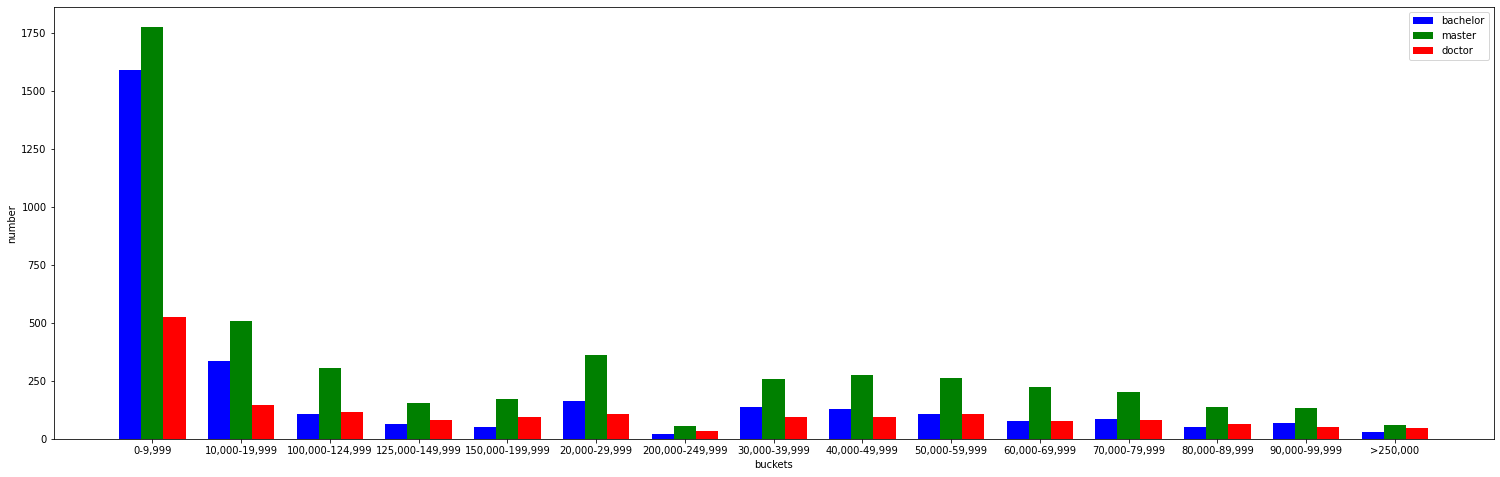

In [23]:
#relationship between degree and salary
fig = plt.figure(figsize=(20,6))
plt.xlabel('buckets')
plt.ylabel('number')
ax = fig.add_axes([0,0,1,1])
X=np.arange(15)
ax.bar(X-0.25, bachelor.values, color = 'b', width = 0.25, label='bachelor')
ax.bar(X, master.values, color = 'g', width = 0.25, label='master')
ax.bar(X+0.25, doctor.values, color = 'r', width = 0.25, label='doctor')
plt.xticks(range(15),index)
plt.xlabel('buckets')
plt.ylabel('number')
plt.legend()

In [24]:
#using correlation matrix we can find the most correlated feature is India and US which are in the country question
#Q3_India  -0.275509  Q3_United States of America  0.519469
salary.corr()['Q24_Encoded'].sort_values().head(10),salary.corr()['Q24_Encoded'].sort_values().tail(10)

(Q3_India             -0.275509
 Q1_22-24             -0.234287
 Q15_Under 1 year     -0.229720
 Q20_0-49 employees   -0.204996
 Q6_1-2 years         -0.200643
 Q21_0                -0.181683
 Q25_$0 ($USD)        -0.174470
 Q1_25-29             -0.162708
 Q6_< 1 years         -0.161473
 Q25_$1-$99           -0.156413
 Name: Q24_Encoded, dtype: float64,
 Q6_10-20 years                                                                                0.185048
 Q25_$10,000-$99,999                                                                           0.213205
 Q21_20+                                                                                       0.214959
 Q15_5-10 years                                                                                0.230563
 Q23_Part_3                                                                                    0.232051
 Q22_We have well established ML methods (i.e., models in production for more than 2 years)    0.245738
 Q6_20+ years       

In [25]:
#use mutual information to select feature
from sklearn.feature_selection import mutual_info_regression
mi=mutual_info_regression(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [26]:
#first 30 important features
feature_index=np.argsort(mi)
best_features=feature_index[-31:-1]
print(X_train.columns[best_features])
X_mi=X_train[X_train.columns[best_features]]
X_mi=X_mi.values
y_train=y_train.values
y_train=np.reshape(y_train,y_train.shape[0])

Index(['Q16_Part_12', 'Q8_Python', 'Q8_MATLAB', 'Q3_Bangladesh', 'Q7_Part_1',
       'Q23_Part_3', 'Q20_250-999 employees', 'Q4_Bachelor’s degree', 'Q21_0',
       'Q25_$0 ($USD)', 'Q2_Woman', 'Q16_Part_5',
       'Q22_No (we do not use ML methods)', 'Q23_Part_1', 'Q1_25-29',
       'Q10_Part_13', 'Q20_0-49 employees', 'Q25_$10,000-$99,999',
       'Q3_United Kingdom of Great Britain and Northern Ireland', 'Q37_OTHER',
       'Q6_1-2 years', 'Q6_< 1 years',
       'Q22_We have well established ML methods (i.e., models in production for more than 2 years)',
       'Q3_Canada', 'Q15_Under 1 year', 'Q21_20+', 'Q15_5-10 years',
       'Q1_22-24', 'Q25_$100,000 or more ($USD)', 'Q3_India'],
      dtype='object')


#Model implementation and tuning

In [27]:
#set up cross validation and implement ordinal LR using skilearn two-class LR in loop
from sklearn.metrics import accuracy_score
def OrdinalLogitR_10fold(model,X,y):
    
  kf = KFold(n_splits=10) #n_splits previously n_folds
  
  fold = 0
  
  accuracy_list=[]

  for train_index, test_index in kf.split(X): #10 fold validation

    fold += 1
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    predictions=[]

    for i in range(0,14): #move i as pivot from 0 to 14, consider left side as 0 and right side as 1

      y_binary_train,y_binary_test=y_train.copy(),y_test.copy()

      np.place(y_binary_train,y_binary_train<=i,0)
      np.place(y_binary_train,y_binary_train>i,1)

      np.place(y_binary_test,y_binary_test<=i,0)
      np.place(y_binary_test,y_binary_test>i,1)

      model.fit(X_train, y_binary_train)
      predictions.append(model.predict_proba(X_test)) 
    
    output=np.zeros((y_test.shape[0],15))
    for i in range(0,15): #compute proba of each class 
      if i==0:
        output[:,i]=predictions[i][:,0]
      else:
        if i==14:
          output[:,i]=predictions[i-1][:,1]
        else:
          output[:,i]=predictions[i][:,0]-predictions[i-1][:,0]
  
    #print('Fold {0} proba: \n {1}'.format(fold,output)) #can be used to show proba of every sample of each class
    pre=np.argmax(output,axis=1)
    accuracy=accuracy_score(y_test,pre)

    print("Fold {0} accuracy: {1}".format(fold, accuracy))
    accuracy_list.append(accuracy)

  mean_accuracy = np.mean(accuracy_list) 
  variance=np.var(accuracy_list)
  print("mean accuracy:",mean_accuracy,"variance:",variance)   


In [28]:
#use data from mi selection in ordinal logistic regression
lor_mi=LogisticRegression(random_state=0,max_iter=1000,solver='saga')
OrdinalLogitR_10fold(lor_mi,X_mi,y_train)

Fold 1 accuracy: 0.39792387543252594
Fold 2 accuracy: 0.4134948096885813
Fold 3 accuracy: 0.39792387543252594
Fold 4 accuracy: 0.356401384083045
Fold 5 accuracy: 0.3719723183391003
Fold 6 accuracy: 0.3546712802768166
Fold 7 accuracy: 0.3737024221453287
Fold 8 accuracy: 0.3806228373702422
Fold 9 accuracy: 0.41074523396880414
Fold 10 accuracy: 0.41421143847487
mean accuracy: 0.387166947521184 variance: 0.00046694032658036637


In [29]:
#change our solver here to see difference
lor_mi=LogisticRegression(random_state=0,max_iter=1000,solver='newton-cg')
OrdinalLogitR_10fold(lor_mi,X_mi,y_train)

Fold 1 accuracy: 0.39792387543252594
Fold 2 accuracy: 0.4134948096885813
Fold 3 accuracy: 0.39792387543252594
Fold 4 accuracy: 0.356401384083045
Fold 5 accuracy: 0.3719723183391003
Fold 6 accuracy: 0.3546712802768166
Fold 7 accuracy: 0.3737024221453287
Fold 8 accuracy: 0.3806228373702422
Fold 9 accuracy: 0.41074523396880414
Fold 10 accuracy: 0.41421143847487
mean accuracy: 0.387166947521184 variance: 0.00046694032658036637


In [30]:
#change our penalty here
#actually there are not many differences
lor_mi=LogisticRegression(random_state=0,penalty='l1',max_iter=1000,solver='saga')
OrdinalLogitR_10fold(lor_mi,X_mi,y_train)

Fold 1 accuracy: 0.39273356401384085
Fold 2 accuracy: 0.41695501730103807
Fold 3 accuracy: 0.39792387543252594
Fold 4 accuracy: 0.35986159169550175
Fold 5 accuracy: 0.3719723183391003
Fold 6 accuracy: 0.356401384083045
Fold 7 accuracy: 0.3685121107266436
Fold 8 accuracy: 0.38408304498269896
Fold 9 accuracy: 0.4124783362218371
Fold 10 accuracy: 0.41594454072790293
mean accuracy: 0.3876865783524135 variance: 0.00047806364223070013


In [31]:
#chi2 feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X_chi2=SelectKBest(chi2,k=30).fit_transform(X_mi,y_train)
lor_chi2 = LogisticRegression(random_state=0,max_iter=1000)
OrdinalLogitR_10fold(lor_chi2,X_chi2,y_train)

Fold 1 accuracy: 0.39792387543252594
Fold 2 accuracy: 0.4134948096885813
Fold 3 accuracy: 0.39792387543252594
Fold 4 accuracy: 0.356401384083045
Fold 5 accuracy: 0.3719723183391003
Fold 6 accuracy: 0.3546712802768166
Fold 7 accuracy: 0.3737024221453287
Fold 8 accuracy: 0.3806228373702422
Fold 9 accuracy: 0.41074523396880414
Fold 10 accuracy: 0.41421143847487
mean accuracy: 0.387166947521184 variance: 0.00046694032658036637


In [33]:
lor_tree = LogisticRegression(random_state=0,max_iter=1000)
OrdinalLogitR_10fold(lor_tree,X_tree,y_train)

Fold 1 accuracy: 0.4083044982698962
Fold 2 accuracy: 0.4031141868512111
Fold 3 accuracy: 0.39100346020761245
Fold 4 accuracy: 0.38235294117647056
Fold 5 accuracy: 0.3737024221453287
Fold 6 accuracy: 0.36678200692041524
Fold 7 accuracy: 0.39100346020761245
Fold 8 accuracy: 0.39100346020761245
Fold 9 accuracy: 0.4194107452339688
Fold 10 accuracy: 0.41421143847487
mean accuracy: 0.3940888619694998 variance: 0.0002657218872252749


In [34]:
#pca feature selection
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
pca.fit(X_train)
X_pca = pca.transform(X_train)
#PCA_X_Test = pca.transform(Salaries_X_Test)
lor_pca = LogisticRegression(random_state=0,max_iter=1000)
OrdinalLogitR_10fold(lor_pca,X_pca,y_train)

Fold 1 accuracy: 0.39792387543252594
Fold 2 accuracy: 0.41522491349480967
Fold 3 accuracy: 0.39965397923875434
Fold 4 accuracy: 0.3754325259515571
Fold 5 accuracy: 0.3806228373702422
Fold 6 accuracy: 0.3754325259515571
Fold 7 accuracy: 0.3944636678200692
Fold 8 accuracy: 0.36505190311418684
Fold 9 accuracy: 0.4038128249566724
Fold 10 accuracy: 0.4124783362218371
mean accuracy: 0.39200973895522123 variance: 0.0002602648251658294


grid search for optimal hyperparameter

In [35]:
from sklearn.metrics import f1_score, make_scorer

logit_gridsearch = LogisticRegression(random_state=0,max_iter=1000)
#Parameters to test
parameters = {'penalty':['l2'], 
             'C':[i for i in np.arange(0.1,1,0.1)]
              ,'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag','saga']} #

# Compare parameters by score of model 
f1_scorer_logitm = make_scorer(f1_score,average='weighted')

# Run the grid search
grid_obj_lm = GridSearchCV(logit_gridsearch, parameters, scoring=f1_scorer_logitm)
grid_obj_lm = grid_obj_lm.fit(X_mi,y_train)

reg_gridsearch = grid_obj_lm.best_estimator_  #Select best parameter combination

In [36]:
best_C=reg_gridsearch.C
penalty_=reg_gridsearch.penalty
solver_=reg_gridsearch.solver
reg_gridsearch

LogisticRegression(C=0.9, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [41]:
#use optimal hyperparameter to train 10-fold 
lor_mi=LogisticRegression(random_state=0,max_iter=1000,solver=solver_,penalty=penalty_,C=best_C)
OrdinalLogitR_10fold(lor_mi,X_mi,y_train)

Fold 1 accuracy: 0.39792387543252594
Fold 2 accuracy: 0.4117647058823529
Fold 3 accuracy: 0.39792387543252594
Fold 4 accuracy: 0.356401384083045
Fold 5 accuracy: 0.3719723183391003
Fold 6 accuracy: 0.3546712802768166
Fold 7 accuracy: 0.3737024221453287
Fold 8 accuracy: 0.38235294117647056
Fold 9 accuracy: 0.41074523396880414
Fold 10 accuracy: 0.41421143847487
mean accuracy: 0.387166947521184 variance: 0.000456164593531193


#Test

In [37]:
X_test_f=X_test[X_test.columns[best_features]]
X_test_f=X_test_f.values
y_test=y_test.values

In [38]:
#change something in the function to make it a train-test function using ordinal LR
def train_test(model,X_train,y_train,X_test,y_test):
    
  predictions=[]
  predictions_train=[]

  for i in range(0,14):

    y_binary_train,y_binary_test=y_train.copy(),y_test.copy()

    np.place(y_binary_train,y_binary_train<=i,0)
    np.place(y_binary_train,y_binary_train>i,1)
    np.place(y_binary_test,y_binary_test<=i,0)
    np.place(y_binary_test,y_binary_test>i,1)

    model.fit(X_train, y_binary_train)
    predictions.append(model.predict_proba(X_test))
    predictions_train.append(model.predict_proba(X_train)) 

  output=np.zeros((y_test.shape[0],15))
  output_train=np.zeros((y_train.shape[0],15))
  for i in range(0,15):
    if i==0:
      output[:,i]=predictions[i][:,0]
      output_train[:,i]=predictions_train[i][:,0]
    else:
      if i==14:
        output[:,i]=predictions[i-1][:,1]
        output_train[:,i]=predictions_train[i-1][:,1]
      else:
        output[:,i]=predictions[i][:,0]-predictions[i-1][:,0]
        output_train[:,i]=predictions_train[i][:,0]-predictions_train[i-1][:,0]
  
  print('proba result:\n',output)
  pre=np.argmax(output,axis=1)
  pre_train=np.argmax(output_train,axis=1)
  accuracy=accuracy_score(y_test,pre)

  print("accuracy:",accuracy)

  return pre,pre_train


In [39]:
#get the final test result
lor_model=LogisticRegression(random_state=0,max_iter=1000,penalty=penalty_,solver=solver_,C=best_C).fit(X_mi,y_train)
pre,pre_train=train_test(lor_model,X_mi,y_train,X_test_f,y_test)

proba result:
 [[ 8.88305806e-01  7.11699841e-02  1.64244884e-02 ...  1.91049476e-04
  -6.70999816e-04  1.48203420e-03]
 [ 5.70033860e-01  2.11564588e-01  8.73846853e-02 ...  3.86617026e-03
   4.86061949e-04  1.21980220e-03]
 [ 1.26254666e-01  8.14905534e-02  9.43497120e-02 ...  4.70873534e-02
   2.24205470e-02  6.45354571e-03]
 ...
 [ 5.49442138e-01  2.76521159e-01  7.51149479e-02 ...  9.11857328e-04
   1.67050665e-04  1.41815360e-04]
 [ 5.59371938e-01  8.49476822e-02  1.05877639e-01 ...  6.06517303e-03
   6.88517019e-03  1.68860307e-02]
 [ 4.85184134e-01  2.49802053e-01  8.67729535e-02 ...  3.18358328e-03
   2.42041255e-04  3.37785817e-04]]
accuracy: 0.3992733144933387


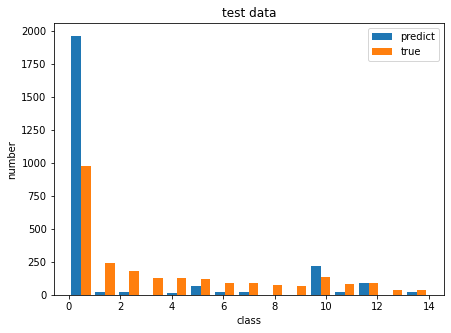

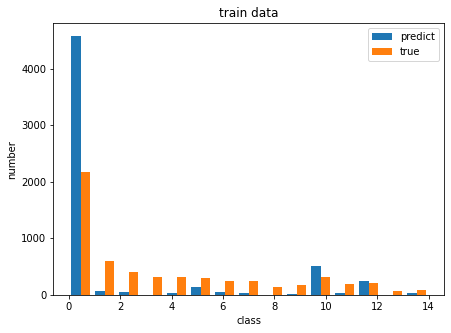

In [40]:
#display the distribution of prediction and ture data in train and test set

plt.figure(figsize=(7,5))
plt.hist([pre,y_test],label=['predict','true'],bins=15)
plt.title('test data')
plt.xlabel('class')
plt.ylabel('number')
plt.legend(loc='upper right')

plt.figure(figsize=(7,5))
plt.hist([pre_train,y_train],label=['predict','true'],bins=15)
plt.title('train data')
plt.xlabel('class')
plt.ylabel('number')
plt.legend(loc='upper right')
plt.show()